# Using SAS DLPy to Create Text Sentiment Analysis Models

You can use SAS DLPy to easily create and train a variety of basic task-oriented deep learning models. Basic model configuration and training parameters can be customized to better tailor the model for your analytic task and data. You can change your model's existing hyperparameter values, as well as add new hyperparameters for advanced training settings. 

The learning objective of this notebook is to understand the mechanics of using SAS DLPy to create two  RNN text classification models, and how to score benchmark data to qualitatively understand how different configurations affect each model's predictive performance. 

Model parameter configuration and optimization depends on the individual analytic task and the data. The different RNN model changes explored in this notebook should not be mistaken for steps to tune or optimize a model. Users should be able to use the tools demonstrated in this notebook to explore their own unique analytic task, data, and model performance, with the goal of potentially identifying a good  candidate model. 

This notebook shows how to create two text classification models. Both models are designed to perform a text sentiment analysis task. The task is to read short restaurant reviews and classify the sentiment of the review text as, `positive`, `negative`, or `neutral`. 

The two text classification sentiment analysis models are created and trained using provided train and test data. Each trained model scores the test data to assess its performance.  The best performing model might be a good candidate for testing with a more extensive data set. 

The example steps include creating train and test data for the analytic task. Like many predicitive text classification models, the models in this notebook require a trained word word embedding to perform the analytic task. This notebook contains detailed instructions to create your own reusable word embedding using publicly available resources.

The example begins by using SAS DLPy to create and train a simple text classification model. Next, a variant of the simple text classification model is created and trained. Both of the text classification models are used to score the test data and the results are compared.  

This example assumes that you have SAS DLPy installed, have an active SAS CAS server, and have installed the common Pyton utilities used in the code (numpy, matplotlib, Pandas).

### Table of Contents 
- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Download a Pre-Trained Word Embedding](#downloadEmbeddings)
    - [Format the Word Embedding for Modeling](#addColHeadings)
    - [Import Required Python and SAS DLPy Modules](#importPythonDLPy)
- [Configure SAS SWAT and Launch SAS CAS](#launchCAS)
    - [Load the Word Embeddings File](#loadEmbeddings)
    - [Create and Load Train Data](#loadTrain)
    - [Create and Load Test Data](#loadTest)
- [Create a Simple Text Classification Model](#Model1)
    - [Train the Simple Model](#trainModel1)
- [Create a Deeper Text Classification Model](#Model2) 
    - [Train the Deeper Model](#trainModel2)
- [Score the Test Data](#scoreData)
    - [Score the Test Data with Simple Model](#scoreModel1)
    - [Score the Test Data with Deeper Model](#scoreModel2)
- [Summary](#summary)   


<a id = "ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system. If the client and server in your environment do not have access to a common file system, you will need to copy or transfer files between client and server during this example.

In [1]:
# This code defines server-side and client-side path variables 
# used in the code to specify the location for input data files,
# and model files in the example. Both paths can point to the 
# same folder in a common file system, but they must use 
# approriate server-side and client-side path syntax.

# Server project root location (your path will be different)
server_project_root = r'/your-server-side/path-to/example-files'

# Client project root location (your path will be different)
client_project_root = r'\\your-client-side\path-to\example-files'

<a id = "getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources you need and configure your local computing environment in advance, so you can follow along with the example notebook modeling operations without interruption. 

<a id="importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Modules

Import the Python utilities and SAS DLPy libraries that will be used for the text classification task. Import utilities for the the pandas data analysis library, the numPy scientific computing library, and the matplotlib plotting utility library.



In [2]:
# Import Matplotlib Utilities  
from matplotlib import pylab as plt
from matplotlib import image as mpimg
# display plot results in notebook cells
%matplotlib inline

# Import Pandas and Numpy libraries
import pandas as pd
import numpy as np

# Import SAS DLPy Python libraries
import dlpy
from dlpy import Sequential
from dlpy import *
from dlpy.model import TextParms
from dlpy.blocks import Bidirectional
from dlpy.applications import TextClassification
from dlpy.network import *
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.layers import *

# Import csv
import csv

# Import os
import os

# Exception handler for reading StringIO text data into memory
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

<a id="downloadEmbeddings"></a>

#### Download a Pre-Trained Word Embedding

Sentiment analysis is one of many NLP machine learning tasks that use a pre-trained word embedding. A word embedding maps word and phrase data into numeric vector data. A typical word embedding might have 50, 100, 200, or 300 dimensions for each word or phrase. Larger dimensions in a word embedding can increase predictive accuracy, potentially at the cost of an increase in the complexity of the model using the embedding. 

Pre-trained word embeddings are an example of transfer learning. A word embeddings model first performs extensive trainining on a massive input corpus of text. Once the extensive training investment is complete, the output word embedding can be used in numerous other NLP models without the significant initial training cost.

Word embedding models use a diverse variety of input text sources for model training. For example, the well-known [Word2Vec](https://code.google.com/archive/p/word2vec/) project in the Google Code Archive includes a model that was trained on a Google News data set of about 100 billion words. The output is a large downloadable word vector file archive GoogleNews-vectors-negative300.bin.gz (1.5 GB) that contains 300 dimensions for 3 million English language words and phrases. You can choose a different text corpus to train Word2Vec: the [Google code archive](https://code.google.com/archive/p/word2vec/) includes links to five other online text corpora that range in size from 1 billion to 3 billion words. The diverse corpora sources include aggregated European News Commentary archives, Wikipedia content dumps, Gigaword repositories in multiple languages, and the historical base from the UMBC (University of Maryland, Baltimore Campus) web archives.   

<b>Note:</b> The Google Word2Vec research project is not a Google product. Word2Vec is licensed for use according to the [Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0) agreement.    

Another well-known word embeddings source is the [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) (Global Vectors for Word Representation) unsupervised learning algorithm developed by Jeffrey Pennington, Richard Socher, and Christopher D. Manning of Stanford University. GloVe models train by determining global word-word co-occurrence statistics from a large text corpus. The Stanford [GloVe site](https://nlp.stanford.edu/pubs/glove.pdf) features a number of word vector archives that were trained on different sizes and types of text corpora. The GloVe site files can be downloaded for use as specified in the [Public Domain Dedication and License v1.0](http://www.opendatacommons.org/licenses/pddl/1.0/) document. 

For example, the [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) (822 MB) word vector archive files were trained on the the Wikipedia 2014 + Gigaword 5 corpus. It features 6 billion tokens and a 400,000 word uncased vocabulary. The archive includes four separate trained word embedding files that have 50, 100, 200, and 300 dimensions, respectively. 

Numerous available word embedding algorithms and software products provide trained word embedding files that are suitable for tutorial and research modeling consumption. This example does not require a specific word embedding table from any specific provider: the choice of provider and word embedding file is left to the modeler.

The toy input data set used in this example is relatively small, so a trained word embedding file with 100 dimensions is more than sufficient. (A 50-dimension word embedding would suffice, but considering the small size of the training data, the increase to 100 dimensions is a trade-off to improve model performance.) The 100-dimension word embedding used in this example was formatted by adding column header information and cleansing the index column. The resulting file is saved as `word_embeddings.txt`. This notebook includes code that you can use to format your choice of trained word embedding file.)

The structure of the word embedding `word_embeddings.txt` used in this example resembles the 100-dimension trained word vector file `glove.6B.100d.txt` that is included in Stanford's Wikipedia 2014 + Gigaword 5 [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) archive. However, you should be able to format and use any one of a number of available trained 100-dimension word embeddings to use with this notebook and deliver fundamentally equivalent predictive results. 

Copy the word embedding of your choice to the folder location you specified earlier as `server_text_generation_root`. The following example section provides code that you can use to format the word embedding data for modeling.

<a id="addColHeadings"></a>

#### Format the Word Embedding for Modeling

Word embedding files typically contain sequential delimited term and vector data in a flat file. The flat file is formatted for model consumption by creating a word vector table with column headings, and then the table is cleansed by removing rows that have forbidden index column values (e.g., quotation marks). The table header row consists of a `term` column, followed by sequential integer headings for each dimension column in the table. For example, a formatted 100-dimension word embedding file has the following column headings: " term , _1_ , _2_ , ... , _99_ , _100_". The `term` column contains character and word strings. The numeric columns contain word vector values for the specified dimension. The number of rows in the table is determined by the size of the source corpus.

If your chosen word embedding file is not formatted and cleansed, you can use the following code to format a "raw" downloaded word embedding file into a table indexed by term, with sequential numbered columns for every dimension of word embedding values. The code also removes table rows for index entries that have reserved or forbidden character string values.

Note: Word embedding files can be large. A typical 100-dimension word embedding file for a corpus of 400,000 terms with 100 vector values per term is a table with over 40 million values. Adjust your expectations for the computation time accordingly. The required time to format a word embeddings file for modeling using the code below scales with the number of dimensions in the raw embedding file.

In [3]:
# Most open-source word embedding files do not have formatted column headings.
# (Use a file viewer to check for column headings and table structure.)
# You can skip this section if your word embedding file already has been cleansed
# and appropriately formatted for modeling.

# Save the word embedding file full path spec to the variable 'raw_embedding_file'.
# This example expects a 100-dimension trained word embedding file in .txt format. 

# Import os
import os

raw_embedding_file = os.path.join(client_project_root,'glove.6B.100d.txt')

# The 'raw_embedding_dimension' parameter should match the  
# number of dimensions in the preferred word embedding file:

# For a 50-dimension word embedding
# raw_embedding_dimension = 50

# For a 100-dimension word embedding
raw_embedding_dimension = 100

# Use variable 'col_names' to accumulate the 
# generated header strings for all table columns.
col_names = ['term'] + ['_'+str(ii)+'_' for ii in range(1,raw_embedding_dimension+1)]

# Pandas reads in the tab-delimited embedding values
# from the word embedding file with no header
df = pd.read_csv(raw_embedding_file, 
                 names=col_names,
                 sep=" ", 
                 index_col=0, 
                 header=None,
                 quoting=csv.QUOTE_NONE)


# Clean up and omit rows in the table that have 
# reserved or forbidden index character strings.
tmp = [str(df.index[ii]) for ii in range(df.shape[0])]
idx = [ii for ii,txt in enumerate(tmp) if ('"' not in txt) and ("'" not in txt)]
df1 = df.iloc[idx]

# Save the updated 100-dimension table with column headings  
# as a new tab-delimited file named 'word_embeddings_100.txt'. 
# Store the full client-side path specification for the word embedding file 
# in the variable 'pretrained_embedding_file'.

pretrained_embedding_file = os.path.join(client_project_root,'word_embeddings_100.txt')
df1.to_csv(pretrained_embedding_file, 
           sep='\t', 
           header=True,
           float_format='%5.6f',
           index=True,
           quoting=csv.QUOTE_NONE)

<a id="startCAS"></a>

### Configure SWAT and Launch SAS CAS 


SAS DLPy requires a running SAS CAS server and Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to CAS. 

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [4]:
# Configure SWAT and launch CAS

# Import SAS SWAT
import swat
from swat import *

# SWAT data message handler
import swat.cas.datamsghandlers as dmh

# Connect to the SAS CAS Server
s = CAS('your-host-name.unx.company-name.com', 5570)

# Exception handler for reading StringIO text data into memory
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

<a id="loadEmbeddings"></a>

#### Load the Word Embedding File

Load the 100-dimension word embedding file that you created. Create a Pandas data frame `embeddings` for the `word_embeddings_100.txt` file, then upload the `embeddings` data frame to SAS CAS as table `word_embeddings_100`. Word embedding files tend to be large, so be patient during processing.

In [5]:
# load word embedding file into SAS CAS
embeddings = pd.read_csv(client_project_root+'\word_embeddings_100.txt',  
                         skipinitialspace=True, 
                         index_col=False, 
                         delimiter='\t'
                         )
s.upload_frame(embeddings, 
               casout=dict(name='word_embeddings_100', 
                           replace=True
                          )
              )

NOTE: Cloud Analytic Services made the uploaded file available as table WORD_EMBEDDINGS_100 in caslib CASUSER(UserID).
NOTE: The table WORD_EMBEDDINGS_100 has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


CASTable('WORD_EMBEDDINGS_100', caslib='CASUSER(UserID)')

In [6]:
# Validate that the word embedding file
# word_embeddings_100 was created.
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,UTF8,1.930519e+09,...,0,0,0,,,0,UserID,,2021-03-04T18:24:04-05:00,1.930519e+09


<a id="loadTrain"></a>

#### Create and Load the Training Data 

After creating the CAS table `WORD_EMBEDDINGS_100`, use the code block below to manually create the toy training data set for the text classification model. The model task is text sentiment analyis. 

The table creation code below contains data for three comma delimited columns: `review` text, `sentiment` classification (`positive`, `neutral`, or `negative`), and a rating of 1 to 5 `stars`. The table is saved in Python as `sentiment_train` and loaded into CAS as table `SENTIMENT_TRAIN`. The `sentiment_train` data set is used to train all of the text classification models in this example.

In [7]:
# Create a toy dataset named sentiment_train  
# to be used for text classification training 
# using restaurant review metadata
# (review,sentiment,stars)

sentiment_train = StringIO('''review,sentiment,stars
 "Average food and average experience.","neutral", 3
 "The desserts are amazing! Love the banana pudding!","positive", 5
 "I love this place. Friendly and welcoming, makes me feel happy!","positive", 5
 "Disappointed. Overpriced cafeteria fare.","negative", 1
 "My favorite place to celebrate birthdays! Yummy cake!","positive", 4
 "Regular chow. Does the job.","neutral", 3
 "Wow! Best burger in years. Extra juicy! Yum!","positive", 5
 "Love a huge side salad! Good value for the money.","positive", 4
 "I don't like cold food. I was disappointed.","negative", 2
 "I don't like fishy smell! Not worth it.","negative", 1
 "Awesome desserts! The best.","positive", 5
 "Predictable comfort food.","neutral", 3
 "Great food and wonderful atmosphere","positive", 5
 "I love this place! Great fun on weekends!","positive", 5 
 "Worst restaurant ever!","negative", 1
 "Such a disaster! Waste of money.","negative", 1
 "Great bartenders. Kim my favorite always makes me happy.", "positive", 5
 "The food is so good! Always pleased. Kudos.", "positive", 4
 "Had a terrible table next to the kitchen. Too loud.", "negative", 2
 "Regular comfort food.","neutral", 3 
 "The whole place smelled bad. Not great.", "negative", 2
 "It was too cold inside. Yuck! I was freezing!", "negative", 2
 "Did not like the sauce. Too spicy.", "negative", 2
 "Most awesome chicken fried steak! Favorite!", "positive", 5
 "The cooks are great! This place rocks!", "positive", 5
 "Chicken was overcooked. So disappointed.", "negative", 2
 "Angry! Was overcharged! Dishonest! Never coming again.", "negative", 1
 "Server forgot our order. What a disaster. Very disappointed.", "negative", 1
 "It was what we expected. Good stuff. Happy.", "positive", 4
 "Slow service, crappy food. Unhappy.", "negative", 2
 "Fast and tasty game day treats! The best!", "positive", 5
 "My favorite place for wings. Yum!", "positive", 4
 "They have problems keeping sour cream. It makes me sad.", "negative", 2
 "Yuck! Fingernail in my food. Gross! Not coming back!", "negative", 1
 "Good place to eat and the hostess is so nice!", "positive", 4
 "Great birthday venue. Happiness all around.", "positive", 5
 "Average cocktails and average beers.", "neutral", 3
 "OK salad bar and OK burgers.", "neutral", 3
 "Very disappointing dining experience." , "negative", 1
 "Sorry waitress disappeared. Aggravating.", "negative", 1
 "Fries were OK.", "neutral", 3
 "Clumsy server spilled tea on me. So disappointed.", "negative", 2
 "Failed to cook my steak properly.", "negative", 1
 "Everything was amazing! Perfect! I'll be back!", "positive", 5
 "Not for me. Shabby. Not like in New York.", "negative", 1 
 "Thrilled to come every time. Fantastic food!", "positive", 5
 "Amazing place. Our favorite for years.", "positive", 5
 "Delightful drinks fabulous food.", "positive", 5
 "Disastrous drinks terrible food.", "negative", 1
 "Fantastic frog legs! Best in the Bayou!", "positive", 5
 "Disgusting frog legs! Worst in the Bayou!", "negative", 1
 "Yummy asparagus best cheesecake in town!", "positive", 5
 "Mushy asparagus worst cheesecake ever.", "negative", 1
 "Best place ever!", "positive", 5
 "Worst place ever.", "negative", 1
 "It was OK.", "neutral", 3
 "Average dining experience.", "neutral", 3
 "Spectacular! Delightful!", "positive", 5
 "Edible and OK.", "neutral", 3
 "Amazing place! My favorite!", "positive", 5
 "Disgusting place! Awful choice.", "negative", 1
 "Gross! My server was sick. Unacceptable!", "negative", 1
 "Unsanitary and disgusting. Got sick at home.", "negative", 1 
 "Super clean! Tasty food! Friendly Staff! Everyone happy!", "positive", 5
 "Mostly average.", "neutral", 3
 "No! A bug in my food! Bad experience.", "negative", 1
 "My server smelled bad. Very unfortunate.", "negative", 2
 "The best chicken cordon bleu ever!", "positive", 5
 "Average drinks and average appetizers.", "neutral", 3
 "Amazing bartender! Best drinks ever!", "positive", 5
 "Fantastic hostess! Great tables!", "positive", 5
 "Average food. OK.", "neutral", 3
 "Forgot my order. Hated the wait ruined the night.", "negative", 1
 "It was food.", "neutral", 3
 "Fast turnover good service good food.", "positive", 4
 "Nightmare experience. Everything went wrong.", "negative", 1
 "Best night ever! So special! Perfect for pre-prom!", "positive", 5
 "Good hot and plenty food.", "positive", 4
 "The food was OK.", "neutral", 3
 "Fast and yummy in my tummy.", "positive", 4
 "Slow boring and below-par experience.", "negative", 2
 "Popular on dates. Everybody leaves happy.", "positive", 4
 "Love this place! Eat here all the time!", "positive", 4
 "Best grits in the South! Love love love it!", "positive", 5
 "Worst grits ever! Disaster using instant grits!", "negative", 1
 "Awful hearing sneezes from the kitchen. Unhealthy and rude!", "negative", 1
 "Yum! The soup of the day is always delicious!", "positive", 4
 "Wonderful for big parties! Great!", "positive", 5
 "Crooks and bums. Bad food, awful service.", "negative", 1
 "Disappointed in my waitress. Needed ketchup.", "negative", 2
 "Server forgot my food. Ate late. Very unhappy.", "negative", 1
 "Most amazing place ever! Delicious!", "positive", 5
 "My favorite! Eat here every day if I can! Yum!", "positive", 5
 "OK experience.", "neutral", 3
 "Everything was OK and average.", "neutral", 3
 "Unhappy. Oysters had gone bad. Got sick. Bleh.", "negative", 1
 "I won't be back. Too much rudeness and ugly behavior.", "negative", 1
 "A reasonable meal. Average.", "neutral", 3
 "Pretty good nachos and great tasty beer.", "positive", 4
 "The best cheesecake EVER!!!", "positive", 5
 "The cheesecake was AWFUL! Ruined!", "negative", 1
 "The cheesecake was from a box. It was OK.", "neutral", 3
 "I did not like the nacho chips. Stale food is bad.", "negative", 2
 "The nachos are wonderful! A taste of home! Love it!", "positive", 5
 "warm entrees OK.", "neutral", 3
 "Amazing appetizers delicious entrees! A winner!", "positive", 5
 "Cold appetizers soggy entrees a sad experience.", "negative", 1
 "They ran out of beer! What a disaster! Awful!", "negative", 1
 "My server stank bad of cigarettes.", "negative", 2
 "They ran out of ice! Bad drinks, bad waits.", "negative", 2
 "The bartender tended the bar.", "neutral", 3
 "My favorite fried cheese ever! Piping hot and yummy!", "positive", 5
 "Worst fried cheese ever! Frozen cold and unappetizing.", "negative", 1
 "The fried cheese was OK.", "neutral", 3
 "The steaks were legendary! Nice size, cooked right.", "positive", 5
 "Best hot dogs ever.", "positive", 5
 "Love the chicken tenders. Happy kid!", "positive", 5
 "Bartender cannot make a good Bongo Smash. Such a shame.", "negative", 2
 "They ran out of beer at 10 pm. Disappointing.", "negative", 2
 "I love the salad bar. Great after-tennis meal.", "positive", 4
 "Amazing place. Our favorite for years.", "positive", 5
 "Delightful drinks and fabulous food.", "positive", 5
 "Disastrous drinks and terrible food.", "negative", 1
 "Fantastic frog legs! Best in the Bayou!", "positive", 5
 "Disgusting frog legs! Worst in the Bayou!", "negative", 1
 "Yummy asparagus, best cheesecake in town!", "positive", 5
 "Mushy asparagus, worst cheesecake ever.", "negative", 1
 "Best place ever!", "positive", 5
 "Worst place ever.", "negative", 1
 "It was OK.", "neutral", 3
 "Amazing.", "positive", 4
 "Acceptable food.", "neutral", 3
 "I had the veal. OK.", "neutral", 3
 "Amazing place! My favorite!", "positive", 5
 "Disgusting place! Terrible choice.", "negative", 1
 "My server was sick. Unacceptable!", "negative", 1
 "Unsanitary and disgusting. Got sick at home.", "negative", 1 
 "The steaks were awful! Too small and overcooked.", "negative", 1
 "OK steaks and OK meal.", "neutral", 3
 "Great steaks.", "positive", 4
 "Steaks were not the best.", "negative", 2
 "Salad was disappointing. Wilty and sad looking.", "negative", 2
 "Delicious crisp salads! Fresh croutons! Great dressings!", "positive", 5
 "Food and salads average.", "neutral", 3
 "Awful salad. Awful food.", "negative", 1
 "Great chicken and good salad.", "positive", 4
 "Salad was bad.", "negative", 2
 "Best breakfast ever!", "positive", 5
 "Worst breakfast ever!", "negative", 1
 "Breakfast was OK.", "neutral", 3
 "Great brunch love the hollandaise and eggs.", "positive", 4
 "Very disappointing brunch. Long wait, bad food.", "negative", 1
 "Amazing brunch. Five stars happy!", "positive", 5
 "It was brunch.", "neutral", 3
 "Tuna salad smelled bad. Unhappy. Would not eat it.", "negative", 2
 "Grossest tuna salad I've ever had. Awful. Won't be back.", "negative", 1
 "Most amazing tuna salad in the world! Winner!", "positive", 5
 "Awful bartender. Couldn't make a Goombay Smash.", "negative", 1
 "Outstanding bartender! Best Goombay Smash ever!", "positive", 5
 "Acceptable Goombay Smash.", "neutral", 3
 "Tastiest frosty beer in the state!  My best choice!", "positive", 5
 "Warm beer stinks! No fun. Fix that broken keg box.", "negative", 2
 "Disaster. No beer. So disappointed.", "negative", 1
 "They had draft beer.", "neutral", 3
 ''')
handler = dmh.CSV(sentiment_train, 
                  skipinitialspace=True
                 )
s.addtable(table='sentiment_train', 
           replace=True, 
           **handler.args.addtable
          )

[caslib]

 'CASUSER(UserID)'

[tableName]

 'SENTIMENT_TRAIN'

[casTable]

 CASTable('SENTIMENT_TRAIN', caslib='CASUSER(UserID)')

+ Elapsed: 0.0264s, user: 0.00144s, sys: 4.8e-05s, mem: 0.805mb

In [8]:
# Verify that the CAS table 
# sentiment_train is created.
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,UTF8,1.930519e+09,...,0,0,0,,,0,UserID,,2021-03-04T18:24:04-05:00,1.930519e+09
1,SENTIMENT_TRAIN,164,3,0,utf-8,2021-03-04T18:26:14-05:00,2021-03-04T18:26:14-05:00,2021-03-04T18:26:14-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN


<a id="loadTest"></a>

#### Create and Load the Test Data 

After creating the CAS training table `SENTIMENT_TRAIN`, use the code block below to  create the toy test data set `sentiment_test`. The test data set will be scored by both text classification models to compare their performance. 

In [9]:
# Now create a toy test dataset named sentiment_test
# to be used for text classification modeling. 
# (review,sentiment,stars)

sentiment_test = StringIO('''review,sentiment,stars
 "Disappointed in the expensive food. Not worth it!","negative", 1
 "Wow! I love this place. The best desserts! ","positive", 5
 "Ordinary meal. OK.","neutral", 3
 "Average dining experience.", "neutral", 3
 "Loved it! Fantastic server and food!", "positive", 5
 "I love the ravioli. It is my favorite!", "positive", 4
 "Rude server forgot us. Disaster! Very disappointed.", "negative", 1
 "Good food. Good staff. Happy.", "positive", 4
 "Slow service, crappy food. Unhappy.", "negative", 2
 "Fast and tasty game day treats! The best!", "positive", 5
 "My favorite place for wings. Yum!", "positive", 4
 "Problems keeping sour cream. It makes me sad.", "negative", 2
 "Yuck! Fingernail in my potatoes. Disgusting! Not coming back!", "negative", 1
 "Good place to eat. Nice hostess too!", "positive", 4
 "Great birthday venue. Happiness all around.", "positive", 5
 "Average cocktails. OK.", "neutral", 3
 "My favorite salad bar and delicious burgers.", "positive", 5
 "Upset. Mixed up my order and ruined my night." , "negative", 1
 "Waitress disappeared. So unhappy.", "negative", 1
 "Fries were awesome and wonderful. Yes!", "positive", 5
 "Best hot dogs ever.", "positive", 5
 "Love the chicken tenders. Happy kid!", "positive", 5
 "Untrained bartender makes bad drinks. Such a shame.", "negative", 2
 "Poor planning no beer at 10 pm. Disappointing.", "negative", 2
 "I love the salad bar. Great meal.", "positive", 4
 "Amazing place. Our favorite for years.", "positive", 5
 "Delightful drinks and fabulous food.", "positive", 5
 "Disastrous drinks and terrible food.", "negative", 1
 "Fantastic frog legs! Best in the Bayou!", "positive", 5
 "Disgusting frog legs! Worst ever!", "negative", 1
 "Yummy asparagus, best cheesecake in town!", "positive", 5
 "Mushy asparagus, worst cheesecake ever.", "negative", 1
 "Best place ever!", "positive", 5
 "Worst place ever.", "negative", 1
 "It was OK.", "neutral", 3
 "Average.", "neutral", 3
 "Amazing food. Hits the spot! Awesome", "positive", 5
 "Delightful food. It's the best.", "positive", 5
 "Amazing place! My favorite!", "positive", 5
 "Disgusting place! Terrible choice.", "negative", 1
 "Awful night my server was sick. Unacceptable!", "negative", 1
 "Unsanitary and disgusting. Bad meal.", "negative", 1 
  "Best pizza ever! Awesome!", "positive", 5
 "Worst calzone ever! Total disappointment.", "negative", 1
 "Terrible pizza place.", "negative", 1
 "Superior service and delightful food!", "positive", 5
 "Really good chow.", "positive", 4
 "Great staff and delicious food!", "positive", 5
 "Best cocktails in New Orleans", "positive", 5
 "I love this bakery! Top class!", "positive", 5
 ''')
handler = dmh.CSV(sentiment_test, 
                  skipinitialspace=True
                 )
s.addtable(table='sentiment_test', 
           replace=True, 
           **handler.args.addtable
          )

[caslib]

 'CASUSER(UserID)'

[tableName]

 'SENTIMENT_TEST'

[casTable]

 CASTable('SENTIMENT_TEST', caslib='CASUSER(UserID)')

+ Elapsed: 0.00923s, user: 0.00122s, sys: 0.000155s, mem: 0.781mb

In [10]:
# Verify that the CAS table 
# sentiment_test is created.
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,UTF8,1.930519e+09,...,0,0,0,,,0,UserID,,2021-03-04T18:24:04-05:00,1.930519e+09
1,SENTIMENT_TRAIN,164,3,0,utf-8,2021-03-04T18:26:14-05:00,2021-03-04T18:26:14-05:00,2021-03-04T18:26:14-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
2,SENTIMENT_TEST,50,3,0,utf-8,2021-03-04T18:31:01-05:00,2021-03-04T18:31:01-05:00,2021-03-04T18:31:01-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN


What do the tables `sentiment_train` and `sentiment_test` look like? 

Use the `fetch` command to view a portion of the data in the test table `sentiment_test`.

In [11]:
# Display five rows from the test table
# sentiment_test.
s.table.fetch(table="sentiment_test", 
              format=True,
              to=5
              )

,review,sentiment,stars
0,Disappointed in the expensive food. Not worth it!,negative,1
1,Wow! I love this place. The best desserts!,positive,5
2,Ordinary meal. OK.,neutral,3
3,Average dining experience.,neutral,3
4,Loved it! Fantastic server and food!,positive,5


<a id="Model1"></a>

### Create a Simple Text Classification Model

Use the SAS DLPy `TextClassification()` function to create a simple RNN text classification model named `simple_model`, and save the model table in SAS CAS as `simple_text_classifier`. 

The simple text classification model is created using default settings. The default model network contains 8 layers: 1 input layer, 3 bi-directional blocks (each consisting of 2 recurrent layers), and 1 output layer.

In [12]:
# create a simple RNN model 
# for text classification
simple_model = TextClassification(s, 
                                  model_table="simple_text_classifier"
                                 )

NOTE: Output layer added.
NOTE: Model compiled successfully.


In [13]:
# Verify that model table SIMPLE_TEXT_CLASSIFIER  
# was created.

s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,UTF8,1.930519e+09,...,0,0,0,,,0,UserID,,2021-03-04T18:24:04-05:00,1.930519e+09
1,SENTIMENT_TRAIN,164,3,0,utf-8,2021-03-04T18:26:14-05:00,2021-03-04T18:26:14-05:00,2021-03-04T18:26:14-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
2,SENTIMENT_TEST,50,3,0,utf-8,2021-03-04T18:31:01-05:00,2021-03-04T18:31:01-05:00,2021-03-04T18:31:15-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
3,SIMPLE_TEXT_CLASSIFIER,121,5,0,utf-8,2021-03-04T18:35:12-05:00,2021-03-04T18:35:12-05:00,2021-03-04T18:35:12-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN


What does the architecture of `simple_model` look like? As an additional exercise, uncomment the bottom line of the code below, and run the cell to generate a DAG of `simple_model`.

In [ ]:
# Generate a DAG for the simple
# text classification model

#simple_model.plot_network()

The generated DAG for the simple text classification model should resemble the following:

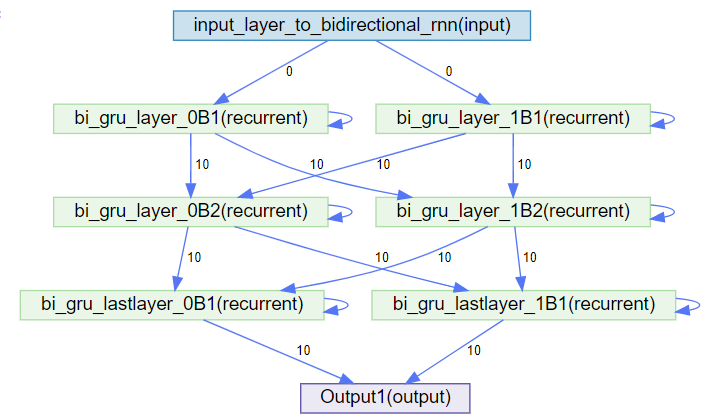

<a id="trainModel1"></a>

#### Train the Simple Text Classification Model

Use the DLPy `fit()` function and `WORD_EMBEDDINGS_100` to train the text classification model `simple_model`. 

The training uses the text data in the `review` column of the input data to predict the value of the nominal class (`positive`, `neutral`, `negative`) in the `sentiment column`. This is a text classification example, so the numeric values in the `stars` column are not used to make predictions.

This notebook creates and trains two model architectures: a simple text classification model and a deeper variant of the simple model. Both models use the same training data and hyperparameter values. The common hyperparameter values provide fair opportunities for both example model architectures to approach convergence during training. Using common training hyperparameters makes it it is easier to explore and qualitatively understand how different network architectures can affect predictive model performance.

The common model training hyperparameter settings are: 

- `mini_batch_size=1`
- `max_epochs=100`
- `lr=0.01`. 

Identical values for `seed` and `n_threads` are also specified to support model determinism and to provide repeatable model training results. Deterministic models always produce the same output from a given set of starting parameters. Using single-threaded computations eliminates computational randomness introduced by multiple threading. This is useful when you want to be able to duplicate example notebook model training results. 

<b>Warning:</b> Using `n_threads=1` to force single-threaded computations for large models or large data sets is not recommended unless you need a fully deterministic model. Allowing multiple threads enables significantly faster model training. It is normal to expect slightly different results in multi-threaded trained models.

In [14]:
# train the simple sentiment analysis model
simple_model.fit(data='sentiment_train', 
                 inputs='review', 
                 texts='review', 
                 target='sentiment', 
                 nominals='sentiment',
                 seed=867,
                 record_seed=5309,
                 n_threads=1,
                 text_parms=TextParms(init_input_embeddings='word_embeddings_100'),
                 mini_batch_size=1, 
                 max_epochs=100, 
                 lr=0.01, 
                 log_level=2
                 )

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 10443.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       2.43 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The maximum mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 1.
NOTE:  Target variable: sentiment
NOTE:  Number of levels for the target variable:      3
NOTE:  Levels for the target variable:
NOTE:  Level      0: negative
NOTE:  Level      1: neutral 
NOTE:  Level      2: positive
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          0.01            1.04     0.5488     0.09
NOTE:  1          0.01           1.003     0.5549     0.08
NOTE:  2          0.01          0.9954     0.5549    

,Descr,Value
0,Model Name,simple_text_classifier
1,Model Type,Recurrent Neural Network
2,Number of Layers,8
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,6
9,Number of Weight Parameters,10260


The resulting trained model has has 10,443 parameters.

The trained model `simple_text_classifier` has a loss of 0.020066 and a fit error of 0.012195. These are encouraging model training performance statistics. The `simple_model` could be a strong predictive model.  We will see when we use it to score the test data set.

Use `tableinfo()` to verify that the trained model weights are saved.

In [15]:
# Verify that the table of trained model 
# weights 'SIMPLE_TEXT_CLASSIFIER_WEIGHTS' 
# was created.
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,2021-03-04T18:57:30-05:00,UTF8,1.930519e+09,...,0,0,0,,,0,UserID,,2021-03-04T18:24:04-05:00,1.930519e+09
1,SENTIMENT_TRAIN,164,3,0,utf-8,2021-03-04T18:26:14-05:00,2021-03-04T18:26:14-05:00,2021-03-04T18:57:30-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
2,SENTIMENT_TEST,50,3,0,utf-8,2021-03-04T18:31:01-05:00,2021-03-04T18:31:01-05:00,2021-03-04T18:31:15-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
3,SIMPLE_TEXT_CLASSIFIER,121,5,0,utf-8,2021-03-04T18:35:12-05:00,2021-03-04T18:35:12-05:00,2021-03-04T18:57:30-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
4,SIMPLE_TEXT_CLASSIFIER_WEIGHTS,10443,3,0,utf-8,2021-03-04T18:57:40-05:00,2021-03-04T18:57:40-05:00,2021-03-04T18:57:40-05:00,UTF8,1.930521e+09,...,0,0,0,,,0,UserID,,,NaN


<a id="model2"></a>

### Create a Deeper Text Classification Model

Create a second, more complex RNN network model to perform text classification. The code that follows uses non-default hyperparameter settings to create a more complex RNN text classification model named `deeper_model`.  

In comparison to the simple text classification model created with default settings, the deeper text classification model increases the number of neurons in each layer from 10 to 20, and increases the number of bi-directional blocks in the model from 3 to 5. 

The model table for `deeper_model` is saved in CAS as `DEEPER_TEXT_CLASSIFIER`.

In [16]:
# Create a more complex text classification model 
# named 'deeper_model'. Save the CAS model table 
# as 'DEEPER_TEXT_CLASSIFIER'. Use 20 neurons per
# layer and use 5 bi-directional blocks to create
# a 12-layer model architecture.

deeper_model = TextClassification(s,
                                  model_table='DEEPER_TEXT_CLASSIFIER',
                                  neurons=20, 
                                  n_blocks=5
                                  )

NOTE: Output layer added.
NOTE: Model compiled successfully.


In [17]:
# Verify that the CAS model table 
# DEEPER_TEXT_CLASSIFIER was created.
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,2021-03-04T18:57:30-05:00,UTF8,1.930519e+09,...,0,0,0,,,0,UserID,,2021-03-04T18:24:04-05:00,1.930519e+09
1,SENTIMENT_TRAIN,164,3,0,utf-8,2021-03-04T18:26:14-05:00,2021-03-04T18:26:14-05:00,2021-03-04T18:57:30-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
2,SENTIMENT_TEST,50,3,0,utf-8,2021-03-04T18:31:01-05:00,2021-03-04T18:31:01-05:00,2021-03-04T18:31:15-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
3,SIMPLE_TEXT_CLASSIFIER,121,5,0,utf-8,2021-03-04T18:35:12-05:00,2021-03-04T18:35:12-05:00,2021-03-04T18:57:30-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
4,SIMPLE_TEXT_CLASSIFIER_WEIGHTS,10443,3,0,utf-8,2021-03-04T18:57:40-05:00,2021-03-04T18:57:40-05:00,2021-03-04T18:57:40-05:00,UTF8,1.930521e+09,...,0,0,0,,,0,UserID,,,NaN
5,DEEPER_TEXT_CLASSIFIER,185,5,0,utf-8,2021-03-04T19:37:42-05:00,2021-03-04T19:37:42-05:00,2021-03-04T19:37:42-05:00,UTF8,1.930524e+09,...,0,0,0,,,0,UserID,,,NaN


What does the architecture of `deeper_model` look like? As an additional exercise, uncomment and run the code block below to generate a DAG for the deeper text classification model.

In [ ]:
# Generate the DAG for the deeper 
# text classification model 
#deeper_model.plot_network()


The generated DAG for the deeper text classification model should resemble the following:

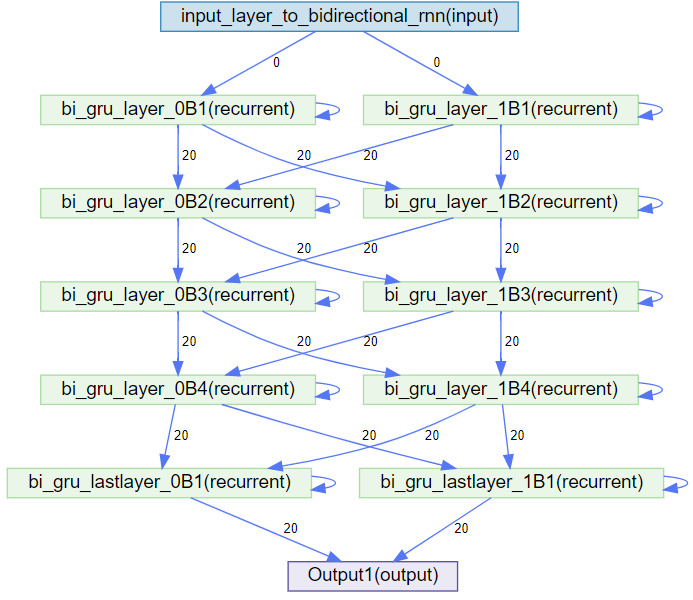

<a id = "trainDeeper"></a>

#### Train the Deeper Text Classification Model

Train the more complex text classification model `deeper_model` using the DLPy `fit()` function and the word embeddings file `WORD_EMBEDDINGS_100`. 

Use the same training data and hyperparameter values as `simple_model`. 

- `mini_batch_size=1`
- `max_epochs=100`
- `lr=0.01`. 

Identical values for `seed` and `n_threads` are also specified to support model determinism and to provide repeatable model training results. Deterministic models always produce the same output from a given set of starting parameters. Using single-threaded computations eliminates computational randomness introduced by multiple threading. This is useful when you want to be able to duplicate example notebook model training results. 

<b>Warning:</b> Using `n_threads=1` to force single-threaded computations for large models or large data sets is not recommended unless you need a fully deterministic model. Allowing multiple threads enables significantly faster model training. It is normal to expect slightly different results in multi-threaded trained models.

In [18]:
# Train the deeper RNN sentiment analysis model
deeper_model.fit(data='sentiment_train', 
                 inputs='review', 
                 texts='review', 
                 target='sentiment', 
                 nominals='sentiment',
                 seed=867,
                 record_seed=5309,
                 n_threads=1,
                 text_parms=TextParms(init_input_embeddings='word_embeddings_100'),
                 mini_batch_size=1, 
                 max_epochs=100, 
                 lr=0.01, 
                 log_level=2
                 )

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 43923.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       2.48 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The maximum mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 1.
NOTE:  Target variable: sentiment
NOTE:  Number of levels for the target variable:      3
NOTE:  Levels for the target variable:
NOTE:  Level      0: negative
NOTE:  Level      1: neutral 
NOTE:  Level      2: positive
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          0.01           1.059     0.5061     0.20
NOTE:  1          0.01           1.059      0.628     0.19
NOTE:  2          0.01           1.016     0.6159    

,Descr,Value
0,Model Name,deeper_text_classifier
1,Model Type,Recurrent Neural Network
2,Number of Layers,12
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,10
9,Number of Weight Parameters,43320


The resulting text classification network is significantly more complex. It has 12 layers instead of 8 layers, and 43,923 model parameters instead of 10,443 model parameters. 

The trained network `deeper_model` has a fit error of 0.334083 and a loss of 0.109756. These are also desirable model training performance statistics. This will also be a strong predictive model. 

When the test data is scored, we will see how the complex network architecture in `deeper_model` performs compared to the basic network architecture in `simple_model`.

<a id="scoreData"></a>

### Score the Test Data

Score the test data set with both of the text classification models and compare the model performances.

<a id = "scoreModel1"></a>

#### Score the Test Data with the Simple Text Classification Model


Use the SAS DLPy `evaluate()` function with `word_embeddings_100` to score the test data `sentiment_test` using the basic text classification model `simple_model`.  

In [19]:
# Score the test data using the trained simple_model and use 
# inference to predict the sentiment of the reviews
simple_model.evaluate(data='sentiment_test',
                      top_probs=2,
                      model_task='CLASSIFICATION',
                      text_parms=TextParms(init_input_embeddings='word_embeddings_100')
                      )

[ScoreInfo]

                                Descr         Value
 0        Number of Observations Read            50
 1        Number of Observations Used            50
 2        Misclassification Error (%)             0
 3  Top 2 Misclassification Error (%)             0
 4                         Loss Error      0.001993

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(UserID)  Valid_Res_2P8NzQ    50       14   
 
                                             casTable  
 0  CASTable('Valid_Res_2P8NzQ', caslib=' CASUSER(U...  

+ Elapsed: 1.92s, user: 5.15s, sys: 1.9s, mem: 560mb

When the trained simple text classification model `simple_model` scores the test data, there is a 0% misclassification error and a loss error of 0.001993.

The scored data statistics indicate a high-performing model. Using the small toy data set, the trained model correctly predicted the sentiment of 100% of the test reviews. This is a strong performing model. 

In a more real-world application, this model would increase in robustness by retraining with a larger and more diverse training data set.  

To explore `simple_model`'s scored table, first use the `tableInfo()` function to find the scored table name. The CAS table at the bottom (beginning with `VALID_RES_`) is the scored result table. 

In [20]:
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,2021-03-04T19:56:38-05:00,UTF8,1.930519e+09,...,0,0,0,,,0,UserID,,2021-03-04T18:24:04-05:00,1.930519e+09
1,SENTIMENT_TRAIN,164,3,0,utf-8,2021-03-04T18:26:14-05:00,2021-03-04T18:26:14-05:00,2021-03-04T19:41:12-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
2,SENTIMENT_TEST,50,3,0,utf-8,2021-03-04T18:31:01-05:00,2021-03-04T18:31:01-05:00,2021-03-04T19:56:38-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
3,SIMPLE_TEXT_CLASSIFIER,121,5,0,utf-8,2021-03-04T18:35:12-05:00,2021-03-04T18:35:12-05:00,2021-03-04T19:56:38-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
4,SIMPLE_TEXT_CLASSIFIER_WEIGHTS,10443,3,0,utf-8,2021-03-04T18:57:40-05:00,2021-03-04T18:57:40-05:00,2021-03-04T19:56:38-05:00,UTF8,1.930521e+09,...,0,0,0,,,0,UserID,,,NaN
5,DEEPER_TEXT_CLASSIFIER,185,5,0,utf-8,2021-03-04T19:37:42-05:00,2021-03-04T19:37:42-05:00,2021-03-04T19:41:12-05:00,UTF8,1.930524e+09,...,0,0,0,,,0,UserID,,,NaN
6,DEEPER_TEXT_CLASSIFIER_WEIGHTS,43923,3,0,utf-8,2021-03-04T19:41:33-05:00,2021-03-04T19:41:33-05:00,2021-03-04T19:41:33-05:00,UTF8,1.930524e+09,...,0,0,0,,,0,UserID,,,NaN
7,VALID_RES_2P8NZQ,50,14,0,utf-8,2021-03-04T19:56:40-05:00,2021-03-04T19:56:40-05:00,2021-03-04T19:56:40-05:00,UTF8,1.930525e+09,...,0,0,0,,,0,UserID,,,NaN


The name of the scored test table in this session is `VALID_RES_2P8NZQ`. Your scored test table will have a different generated name. 

Use the `VALID_RES_2P8NZQ` table name with the `table.fetch()` function to display 10 rows of the `simple_model` scored test data.

In [21]:
# Show the first 10 rows of the scored data  
# in VALID_RES_2P8NZQ for 'simple_model':
s.table.fetch(table="VALID_RES_2P8NZQ", 
              format=True,
              to=10)

,review,sentiment,stars,P_sentimentnegative,P_sentimentneutral,P_sentimentpositive,I_sentiment,_DL_PredP_,_DL_PredLevel_,_DL_TOP_P0_,_DL_TOP_PredName0_,_DL_TOP_P1_,_DL_TOP_PredName1_,_DL_TOP_Missit_
0,Disappointed in the expensive food. Not worth it!,negative,1,0.999414444,0.0002259702,0.0003595504,negative,0.999414444,0,0.999414444,negative,0.0003595504,positive,0
1,Wow! I love this place. The best desserts!,positive,5,0.0002769455,0.0001083846,0.9996145964,positive,0.9996145964,2,0.9996145964,positive,0.0002769455,negative,0
2,Ordinary meal. OK.,neutral,3,0.0021557852,0.9968801737,0.0009640018,neutral,0.9968801737,1,0.9968801737,neutral,0.0021557852,negative,0
3,Average dining experience.,neutral,3,0.00399424,0.993796587,0.0022091896,neutral,0.993796587,1,0.993796587,neutral,0.00399424,negative,0
4,Loved it! Fantastic server and food!,positive,5,0.0003737449,0.0001437709,0.9994825125,positive,0.9994825125,2,0.9994825125,positive,0.0003737449,negative,0
5,I love the ravioli. It is my favorite!,positive,4,0.0003075374,0.0001306836,0.999561727,positive,0.999561727,2,0.999561727,positive,0.0003075374,negative,0
6,Rude server forgot us. Disaster! Very disappoi...,negative,1,0.9994939566,0.000093668,0.0004123807,negative,0.9994939566,0,0.9994939566,negative,0.0004123807,positive,0
7,Good food. Good staff. Happy.,positive,4,0.0003264701,0.0001952127,0.9994783998,positive,0.9994783998,2,0.9994783998,positive,0.0003264701,negative,0
8,"Slow service, crummy food. Unhappy.",negative,2,0.9992652535,0.0003961412,0.000338593,negative,0.9992652535,0,0.9992652535,negative,0.0003961412,neutral,0
9,Fast and tasty game day treats! The best!,positive,5,0.0002705452,0.0001306097,0.9995989203,positive,0.9995989203,2,0.9995989203,positive,0.0002705452,negative,0


<a id = "scoreModel2"></a>

#### Score the Test Data with the Deeper Text Classification Model

Use the DLPy `evaluate()` function and `word_embeddings_100` to score the test data using the more complext text classification model `deeper_model`. 

In [22]:
# Score the test data using trained text classification
# model 'deeper_model'. Inference will predict the sentiment 
# of the reviews in the test table.
deeper_model.evaluate(data='sentiment_test',
                      top_probs=2, 
                      model_task='CLASSIFICATION',
                      text_parms=TextParms(init_input_embeddings='word_embeddings_100')
                      )

[ScoreInfo]

                                Descr         Value
 0        Number of Observations Read            50
 1        Number of Observations Used            50
 2        Misclassification Error (%)             2
 3  Top 2 Misclassification Error (%)             0
 4                         Loss Error      0.181052

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(UserID)  Valid_Res_W0OtyI    50       14   
 
                                             casTable  
 0  CASTable('Valid_Res_W0OtyI', caslib=' CASUSER(U...  

+ Elapsed: 1.93s, user: 5.03s, sys: 1.88s, mem: 553mb

When the trained text classification model `deeper_model` scores the test data, there is a 2% misclassification error and a loss error of 0.181052. 

The scored data statistics indicate a high-performing model. Using the small toy data set, the trained model correctly predicted the sentiment of 98% of the test reviews. This is a strong performing model. 

To explore `deeper_model`'s scored table, first use the `tableInfo()` function to find the scored table name. The CAS table at the bottom (beginning with `VALID_RES_`) is the scored result table. 

In [23]:
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-03-04T18:24:04-05:00,2021-03-04T18:24:04-05:00,2021-03-04T20:08:55-05:00,UTF8,1.930519e+09,...,0,0,0,,,0,UserID,,2021-03-04T18:24:04-05:00,1.930519e+09
1,SENTIMENT_TRAIN,164,3,0,utf-8,2021-03-04T18:26:14-05:00,2021-03-04T18:26:14-05:00,2021-03-04T19:41:12-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
2,SENTIMENT_TEST,50,3,0,utf-8,2021-03-04T18:31:01-05:00,2021-03-04T18:31:01-05:00,2021-03-04T20:08:55-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
3,SIMPLE_TEXT_CLASSIFIER,121,5,0,utf-8,2021-03-04T18:35:12-05:00,2021-03-04T18:35:12-05:00,2021-03-04T19:56:38-05:00,UTF8,1.930520e+09,...,0,0,0,,,0,UserID,,,NaN
4,SIMPLE_TEXT_CLASSIFIER_WEIGHTS,10443,3,0,utf-8,2021-03-04T18:57:40-05:00,2021-03-04T18:57:40-05:00,2021-03-04T19:56:38-05:00,UTF8,1.930521e+09,...,0,0,0,,,0,UserID,,,NaN
5,DEEPER_TEXT_CLASSIFIER,185,5,0,utf-8,2021-03-04T19:37:42-05:00,2021-03-04T19:37:42-05:00,2021-03-04T20:08:55-05:00,UTF8,1.930524e+09,...,0,0,0,,,0,UserID,,,NaN
6,DEEPER_TEXT_CLASSIFIER_WEIGHTS,43923,3,0,utf-8,2021-03-04T19:41:33-05:00,2021-03-04T19:41:33-05:00,2021-03-04T20:08:55-05:00,UTF8,1.930524e+09,...,0,0,0,,,0,UserID,,,NaN
7,VALID_RES_2P8NZQ,50,14,0,utf-8,2021-03-04T19:56:40-05:00,2021-03-04T19:56:40-05:00,2021-03-04T20:07:42-05:00,UTF8,1.930525e+09,...,0,0,0,,,0,UserID,,,NaN
8,VALID_RES_W0OTYI,50,14,0,utf-8,2021-03-04T20:08:57-05:00,2021-03-04T20:08:57-05:00,2021-03-04T20:08:57-05:00,UTF8,1.930526e+09,...,0,0,0,,,0,UserID,,,NaN


The name of the scored test table in this session is `VALID_RES_W0OTYI`. Your scored test table will have a different generated name. 

Use the `VALID_RES_W0OTYI` table name with the `table.fetch()` function to display 10 rows of the `simple_model` scored test data.

In [24]:
# Show the first 10 rows of the scored data  
# in VALID_RES_W0OTYI for deeper_model:
s.table.fetch(table="VALID_RES_W0OTYI", 
              format=True,
              to=10)

,review,sentiment,stars,P_sentimentnegative,P_sentimentneutral,P_sentimentpositive,I_sentiment,_DL_PredP_,_DL_PredLevel_,_DL_TOP_P0_,_DL_TOP_PredName0_,_DL_TOP_P1_,_DL_TOP_PredName1_,_DL_TOP_Missit_
0,Disappointed in the expensive food. Not worth it!,negative,1,0.9622451663,0.0208706055,0.0168842245,negative,0.9622451663,0,0.9622451663,negative,0.0208706055,neutral,0
1,Wow! I love this place. The best desserts!,positive,5,0.0145642944,0.0000116781,0.9854239821,positive,0.9854239821,2,0.9854239821,positive,0.0145642944,negative,0
2,Ordinary meal. OK.,neutral,3,0.3218136132,0.6689260602,0.009260267,neutral,0.6689260602,1,0.6689260602,neutral,0.3218136132,negative,0
3,Average dining experience.,neutral,3,0.2667362988,0.7174137235,0.0158500206,neutral,0.7174137235,1,0.7174137235,neutral,0.2667362988,negative,0
4,Loved it! Fantastic server and food!,positive,5,0.0242295545,0.0000307736,0.9757397175,positive,0.9757397175,2,0.9757397175,positive,0.0242295545,negative,0
5,I love the ravioli. It is my favorite!,positive,4,0.0439963192,0.0000346883,0.9559690356,positive,0.9559690356,2,0.9559690356,positive,0.0439963192,negative,0
6,Rude server forgot us. Disaster! Very disappoi...,negative,1,0.9645784497,0.0131327361,0.022288844,negative,0.9645784497,0,0.9645784497,negative,0.022288844,positive,0
7,Good food. Good staff. Happy.,positive,4,0.0260364413,0.0000329691,0.9739305377,positive,0.9739305377,2,0.9739305377,positive,0.0260364413,negative,0
8,"Slow service, crummy food. Unhappy.",negative,2,0.9232894182,0.0552817024,0.0214288719,negative,0.9232894182,0,0.9232894182,negative,0.0552817024,neutral,0
9,Fast and tasty game day treats! The best!,positive,5,0.0162644926,0.0000145699,0.9837208986,positive,0.9837208986,2,0.9837208986,positive,0.0162644926,negative,0


<a id="summary"></a>

### Summary

It is relatively easy to create and modify task-centric models using SAS DLPy. This example showed how to create two different text classification models with different architectures to perform a text sentiment analysis task.

Both models in this notebook example perform well (0% and 2% misclassifications, respectively) using the supplied toy data set.  

There are a variety of hyperparameters that affect model training.  Experimenting to find the right configuration of hyperparameter settings for a given task and input data is essential for good predictive model performance. Exploring the performance of different model training configurations can help find a good starting candidate for focused hyperparameter tuning.